In [1]:
using DataFrames, Statistics, LinearAlgebra, Plots, CategoricalArrays, UMAP, DuckDB 
using Distributions, StatsPlots, StatsBase, TSne, CSV, Optim, Arrow, Parquet, GigaSOM
using Turing
using Turing.RandomMeasures

In [2]:
df = DataFrame(Arrow.Table("C:/Users/nicol/Documents/GSE71678/Data/processed_data/GSE71678_cov_imputed.arrow"))
show(df)

343×30 DataFrame
 Row │ ID          tissue          species       infant gender  maternal age   ⋯
     │ String?     String?         String?       String?        Float64?       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ GSM1842804  Human placenta  Homo sapiens  Female              35.2991   ⋯
   2 │ GSM1842805  Human placenta  Homo sapiens  Female              30.705
   3 │ GSM1842806  Human placenta  Homo sapiens  Female              24.3504
   4 │ GSM1842807  Human placenta  Homo sapiens  Male                23.7344
   5 │ GSM1842808  Human placenta  Homo sapiens  Male                27.2663   ⋯
   6 │ GSM1842809  Human placenta  Homo sapiens  Male                35.1704
   7 │ GSM1842810  Human placenta  Homo sapiens  Female              32.1999
   8 │ GSM1842811  Human placenta  Homo sapiens  Male                36.8296
   9 │ GSM1842812  Human placenta  Homo sapiens  Female              28.4901   ⋯
  10 │ GSM1842813  Human placenta  H

In [3]:
cpgs = DataFrame(Arrow.Table("C:/Users/nicol/Documents/GSE71678/Data/processed_data/GSE71678_cpgs_original.arrow"))
show(cpgs)

344348×344 DataFrame
    Row │ ID_REF          GSM1842804  GSM1842805  GSM1842806  GSM1842807  GSM1 ⋯
        │ String?         Float64?    Float64?    Float64?    Float64?    Floa ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │ cg00000029      0.0374105    0.0514671  0.040893     0.0446512  0.03 ⋯
      2 │ cg00000109      0.668485     0.787928   0.881112     0.833583   0.84
      3 │ cg00000165      0.447777     0.541943   0.635017     0.577039   0.81
      4 │ cg00000236      0.715317     0.786614   0.862014     0.828858   0.80
      5 │ cg00000289      0.501125     0.572259   0.74443      0.630202   0.63 ⋯
      6 │ cg00000321      0.733153     0.577599   0.458774     0.472016   0.45
      7 │ cg00000363      0.310761     0.320595   0.289607     0.307417   0.36
      8 │ cg00000622      0.0111285    0.0171817  0.0138852    0.0099766  0.01
      9 │ cg00000658      0.835529     0.799546   0.833648     0.799387   0.83 ⋯
     10 │ cg0000071

In [4]:
n_cpgs = sample(1:size(cpgs,1),50000);
Xcpgs = Matrix{Float64}(cpgs[:,2:344]);

In [5]:
metals = names(df)[[8,10,11,12,13,14,15,16]]

8-element Vector{String}:
 "placental as levels"
 "urinary as"
 "placenta_al"
 "placenta_cr"
 "placenta_ni"
 "placenta_se"
 "placenta_co"
 "placenta_pb"

In [6]:
#d = randn(10000,4) .+ rand(0:1, 10000, 4).*10;
Xcpgs = Matrix{Float64}(df[:,metals]);

In [7]:
som = initGigaSOM(Xcpgs, 20, 20)
som = trainGigaSOM(som, Xcpgs)

Som([1.905 4.236 … 8.7016549883 6.1926485693; 1.4655 3.58371291235556 … 5.91402202875 3.81096500125; … ; 0.9512846144790005 5.93323055343078 … 8.786874899175 0.983828153175; 0.642827284 7.46114213562373 … 5.822141118 0.707376937], 20, 20, 400, [0.0 0.0; 1.0 0.0; … ; 18.0 19.0; 19.0 19.0])

In [8]:
mapToGigaSOM(som, Xcpgs);

In [9]:
e = embedGigaSOM(som,Xcpgs);

In [10]:
g6 = d[:,2] .>= 5;

LoadError: UndefVarError: d not defined

In [11]:
x_col = recode(g6, "0"=>1::Int64, "1"=>2::Int64);
colors=[:coral, :yellow2, :lime, :turquoise2, :magenta, :dimgray]

LoadError: UndefVarError: g6 not defined

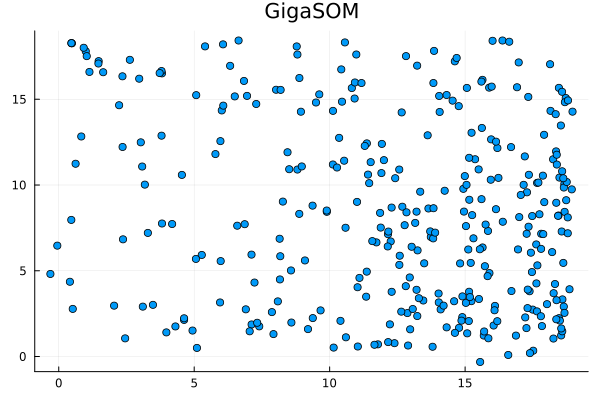

In [12]:
# mc=colors[x_spec], 
scatter(e[:,1],e[:,2], title = "GigaSOM", labels = "")

In [13]:
y_tsne = tsne(Xcpgs, 2, 8, 1000, 30, pca_init = true, progress = false);   

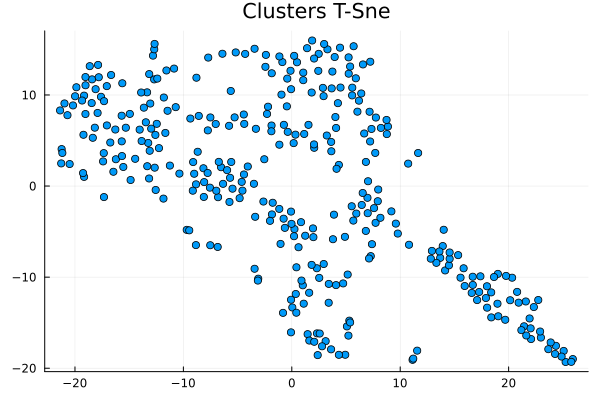

In [14]:
scatter(y_tsne[:,1], y_tsne[:,2], title = "Clusters T-Sne", labels = "")

In [15]:
umap_model = umap(Xcpgs', 2, n_epochs = 500)

2×343 Matrix{Float64}:
 -8.447    -8.24406  -0.178397  -1.04768   …  1.69979  0.0653085  -7.35428
  2.12363   1.97918  -0.508231   0.350728     2.27558  4.01505    -0.0226532

In [16]:
countmap(cut(df[:,"birth weight (grams)"],[0,2800,3200,3500,3700,4000,10000]))
#histogram(df[:,"birth weight (grams)"])

Dict{Union{Missing, CategoricalValue{String, UInt32}}, Int64} with 6 entries:
  "[3200, 3500)"  => 72
  "[2800, 3200)"  => 83
  "[3700, 4000)"  => 55
  "[4000, 10000)" => 42
  "[3500, 3700)"  => 61
  "[0, 2800)"     => 30

In [17]:
colors=[:coral, :yellow2, :lime, :turquoise2, :magenta, :dimgray];
col_preterm = recode(df[:,"gestational age"] .< 37, 0=>1::Int64, 1=>2::Int64);
col_gender = recode(df[:,"infant gender"] .== "Female", 0=>1::Int64, 1=>2::Int64);
col_mage = recode(cut(df[:,"maternal age"],[18,27,30,32,35,37,50]), 
    "[35, 37)" => 1::Int64,
    "[18, 27)" => 2::Int64,
    "[27, 30)" => 3::Int64,
    "[37, 50)" => 4::Int64,
    "[30, 32)" => 5::Int64,
    "[32, 35)" => 6::Int64);
col_mage = Array{Int64}(col_mage);
col_bw = recode(cut(df[:,"birth weight (grams)"],[0,2800,3200,3500,3700,4000,10000]), 
    "[3200, 3500)" => 1::Int64,
    "[2800, 3200)" => 2::Int64,
    "[3700, 4000)" => 3::Int64,
    "[4000, 10000)" => 4::Int64,
    "[3500, 3700)" => 5::Int64,
    "[0, 2800)" => 6::Int64);
col_bw = Array{Int64}(col_bw);

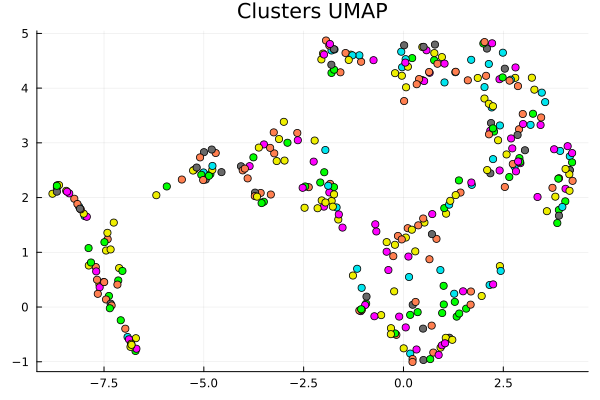

In [18]:
scatter(umap_model[1,:], umap_model[2,:], mc=colors[col_bw], title = "Clusters UMAP", labels = "")

In [19]:
cluster_1 = umap_model[1,:] .< -3.8
countmap(df[cluster_1,"ever_smoker"])
describe(df[cluster_1,1:22])

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Union
1,ID,,GSM1842804,,GSM1843146,0,"Union{Missing, String}"
2,tissue,,Human placenta,,Human placenta,0,"Union{Missing, String}"
3,species,,Homo sapiens,,Homo sapiens,0,"Union{Missing, String}"
4,infant gender,,Female,,Male,0,"Union{Missing, String}"
5,maternal age,31.5236,20.4408,31.5099,44.7639,0,"Union{Missing, Float64}"
6,birth weight (grams),3337.58,1680.0,3360.0,4530.0,0,"Union{Missing, Float64}"
7,gestational age,39.1496,32.0857,39.29,41.1429,0,"Union{Missing, Float64}"
8,placental as levels,1.50229,0.0348914,1.21067,16.486,0,"Union{Missing, Float64}"
9,post-partum maternal toenail as,0.0622911,0.002,0.051,0.4,0,"Union{Missing, Float64}"


In [20]:
countmap(df[cluster_1,"mom_education"])

Dict{Union{Missing, String}, Int64} with 5 entries:
  "College graduate"            => 30
  "HS grad"                     => 12
  "Jr College/technical school" => 16
  "Any post-grad"               => 20
  "<11th grade"                 => 1

In [21]:
countmap(df[:,"mom_education"])

Dict{Union{Missing, String}, Int64} with 5 entries:
  "College graduate"            => 142
  "HS grad"                     => 39
  "Jr College/technical school" => 67
  "Any post-grad"               => 92
  "<11th grade"                 => 3